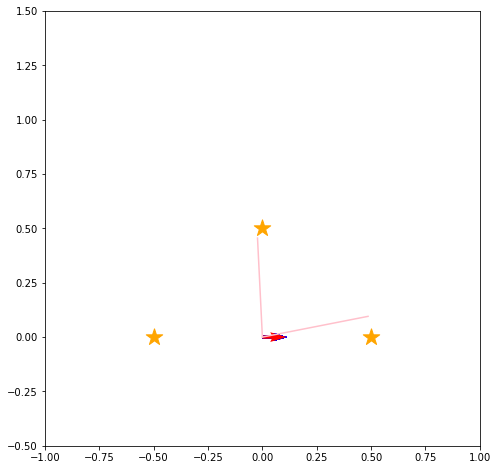

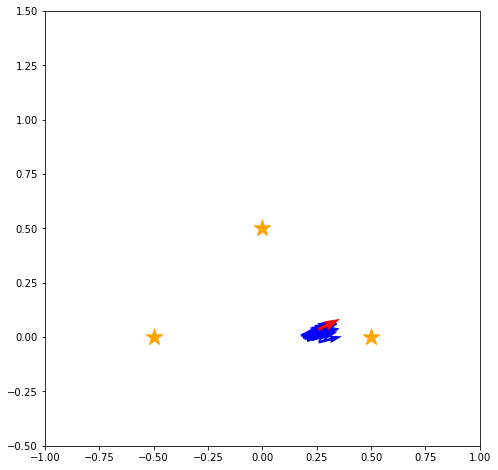

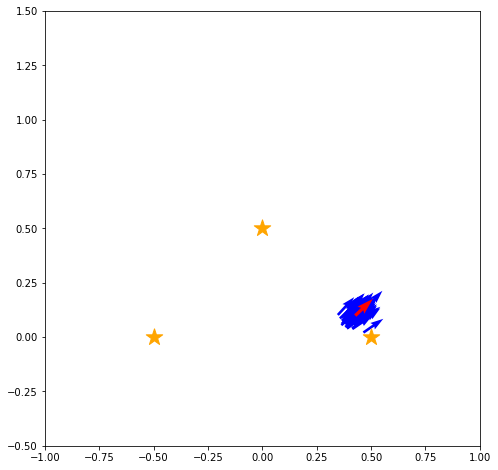

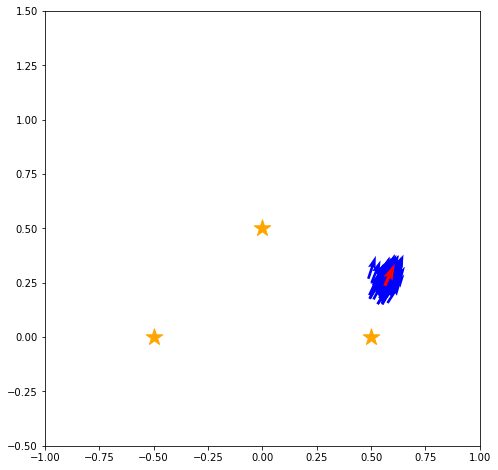

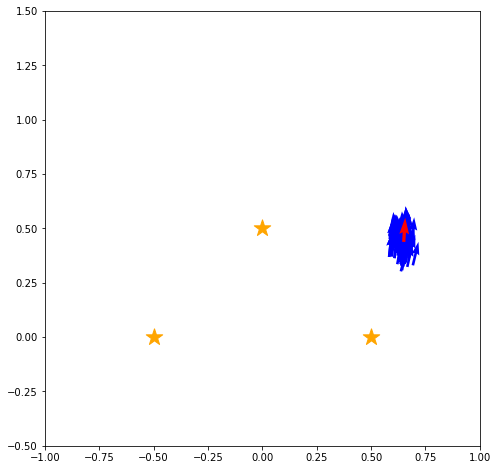

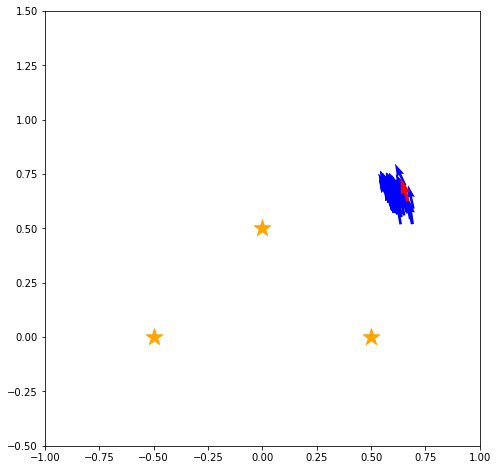

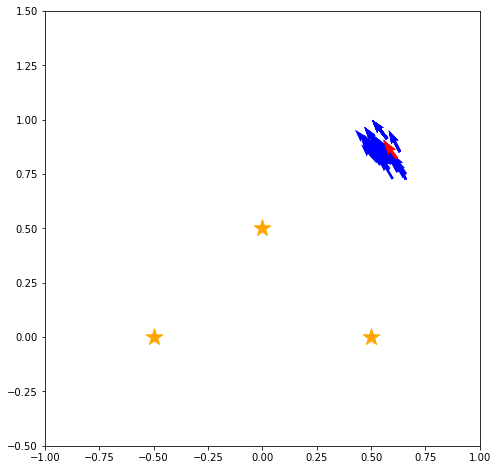

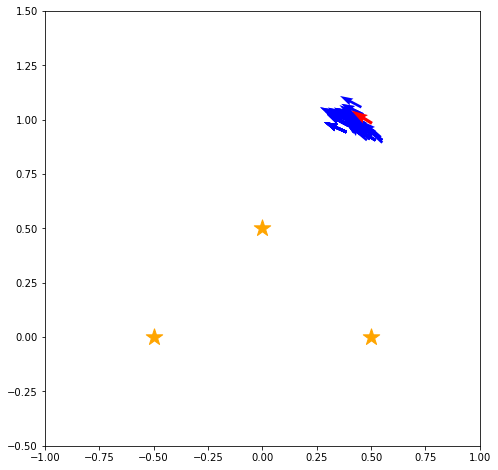

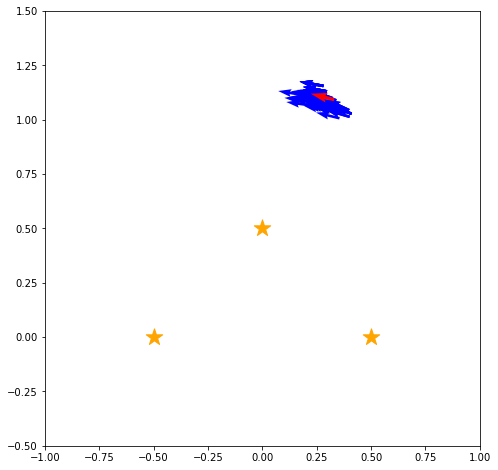

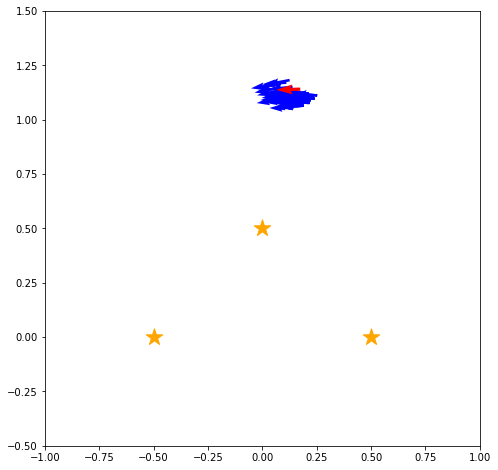

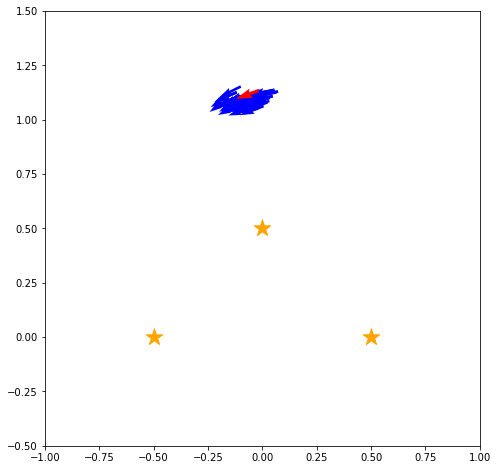

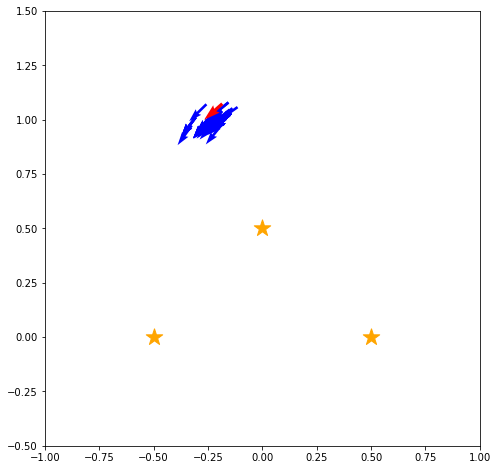

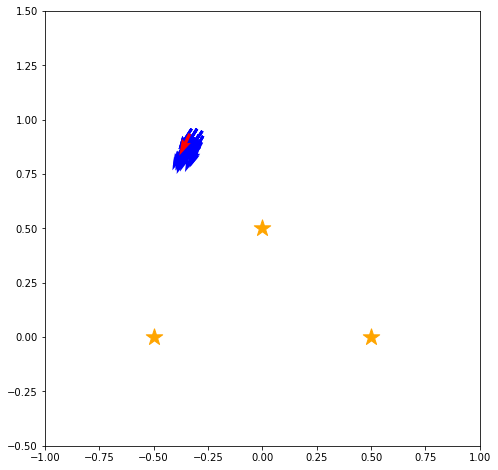

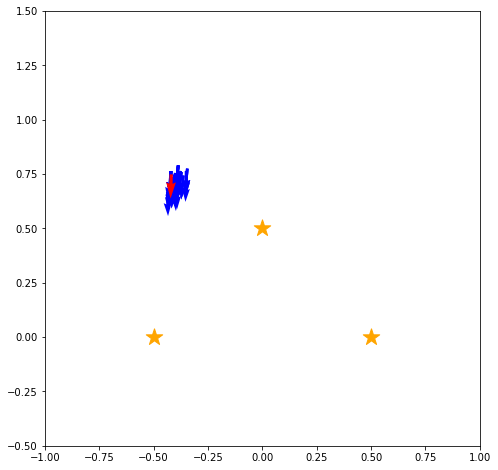

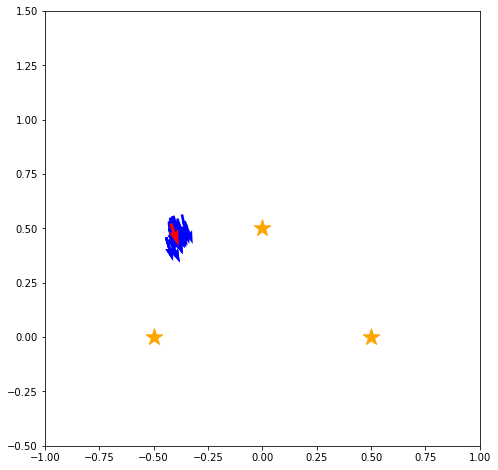

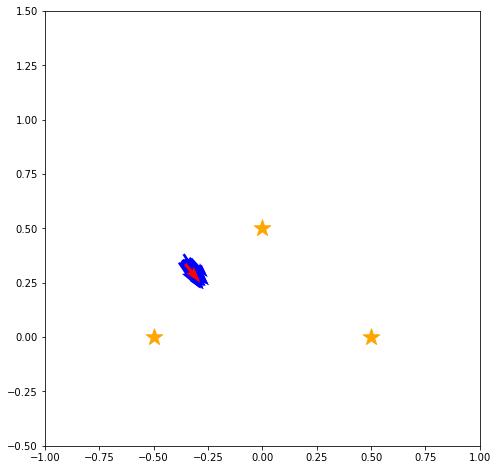

In [1]:
import numpy as np
import copy
import math, random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm

def draw_landmarks(landmarks):
    xs = [ e[0] for e in landmarks ]
    ys = [ e[1] for e in landmarks ]
    plt.scatter(xs,ys, s=300, marker="*", label ="landmarks", color="orange")

def draw_robot(pose):
    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="actual robot motion")
    
def relative_landmark_pos(pose,landmark):
    x,y,th =pose
    lx,ly = landmark
    distance  = math.sqrt((x-lx)**2 + (y-ly)**2)
    direction = math.atan2(ly-y, lx-x) - th
    
    return (distance, direction, lx, ly)

def draw_observation(pose, measurment):
    x,y,th =pose
    distance, direction,lx,ly = measurment
    lx = distance * math.cos(th + direction) + x
    ly = distance * math.sin(th + direction) + y
    plt.plot([x, lx],[y, ly],color="pink")
    
def draw_observations(pose,  measurements):
    for m in measurements:
        draw_observation(pose, m)

def observation(pose, landmark):
    actual_distance, actual_direction,lx,ly = relative_landmark_pos(pose,landmark)
    
    if(math.cos(actual_direction) < 0.0 ):
        return None
    
    measured_distance = random.gauss(actual_distance, actual_distance*0.1) #10% error
    measured_direction = random.gauss(actual_direction,5.0/180.0*math.pi) #5deg error
    return (measured_distance, measured_direction,lx,ly)

def observations(pose,landmarks):
    return filter(lambda x: x != None, [ observation(pose,e) for e in landmarks])

def likelihood(pose, measurement):
    x,y,th = pose
    distance, direction,lx,ly = measurement
    
    rel_distance, rel_direction, tmp_x, tmp_y = relative_landmark_pos(pose,(lx,ly))

    return norm.pdf(x = distance - rel_distance, loc = 0.0, scale = rel_distance / 10.0)  \
    * norm.pdf(x = direction - rel_direction, loc = 0.0, scale = 5.0/180.0 * math.pi)

def change_weights(particles, measurement):
    for p in particles:
        p.weight *= likelihood(p.pose, measurement)
        
    ws = [ p.weight for p in particles ]
    s = sum(ws)
    for p in particles:
        p.weight = p.weight / s

class Particles:
    def __init__(self,pose, w ):
        self.pose = np.array(pose)
        self.weight = w
        
    def __repr__(self):
        return "pose: " + str(self.pose) + "weight: " + str(self.weight)

def motion(pose,u):
    p_x, p_y, p_th = pose
    fw, rot = u
    
    actual_fw = random.gauss(fw, fw/10)
    dir_error = random.gauss(0.0, math.pi/ 180.0 * 3.0)
    actual_rot     = random.gauss(rot,rot/10)
    
    p_x += actual_fw * math.cos(p_th + dir_error)
    p_y += actual_fw * math.sin(p_th + dir_error)
    p_th += actual_rot + dir_error
    
    return np.array([p_x, p_y, p_th])

def draw(pose,particles):
    fig = plt.figure(i, figsize= (8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)
    
    xs = [e.pose[0] for e in particles]
    ys = [e.pose[1] for e in particles]
    vxs = [math.cos(e.pose[2])*e.weight for e in particles]
    vys = [math.sin(e.pose[2])*e.weight for e in particles]
    plt.quiver(xs,ys,vxs,vys,color="blue",label="particles")

    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="actual robot motion")
    
if __name__ == '__main__':
    actual_x = np.array([0.0,0.0,0.0])
    u = np.array([0.2,math.pi / 180.0 * 20])
    actual_landmarks =[np.array([-0.5,0.0]),np.array([0.5,0.0]),np.array([0.0,0.5])]
    particles = [Particles([0.0,0.0,0.0],1.0/100) for i in range(100)] ## 100 ##

    path = [actual_x]
    particle_path = [copy.deepcopy(particles)]
    measurements = [observations(actual_x, actual_landmarks)]

    for i in range(15):
        actual_x = motion(actual_x,u)
        path.append(actual_x)

        ms = observations(actual_x, actual_landmarks)
        measurements.append(ms)
        
        for p in particles:
            p.pose = motion(p.pose,u)
            
        for m in ms:
            change_weights(particles, m)

        pointer = random.uniform(0.0,1.0/len(particles))
        new_particles = []
        particles_num = len(particles)

     
        accum =[]
        sm = 0.0
        for p in particles:
            accum.append(p.weight + sm)
            sm += p.weight

        while pointer < 1.0:
            if accum[0] >= pointer:
                new_particles.append(
                    Particles(copy.deepcopy(particles[0].pose),1.0/particles_num)
                )
                pointer += 1.0/particles_num
            else:
                accum.pop(0)
                particles.pop(0)
        
        particles = new_particles

        particle_path.append(copy.deepcopy(particles))

for i,p in enumerate(path):
    draw(path[i],particle_path[i])
    draw_landmarks(actual_landmarks)
    draw_observations(path[i], measurements[i])
    plt.show()            
